In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Loading data...")
df = pd.read_csv('forestfires_classification.csv')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['area'].value_counts()}")

Loading data...
Dataset shape: (517, 13)
Class distribution:
area
T    292
F    225
Name: count, dtype: int64


In [5]:
def preprocess_data(df):
    df_clean = df.copy()
    
    # Encode categorical variables
    month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    day_order = ['mon','tue','wed','thu','fri','sat','sun']
    
    df_clean['month'] = df_clean['month'].apply(lambda x: month_order.index(x))
    df_clean['day'] = df_clean['day'].apply(lambda x: day_order.index(x))
    
    # Transform skewed rain variable
    df_clean['rain'] = np.log1p(df_clean['rain'])
    
    # Encode target
    df_clean['area'] = df_clean['area'].map({'F': 0, 'T': 1})
    
    return df_clean

df_processed = preprocess_data(df)


--- Data Preparation: Rain Variable Cleaning ---
Rain variable analysis:
  - Zero values: 509/517 = 98.5%
  - Max rainfall: 6.40 mm
  - Skewness (before): 19.76
  - Skewness (after log): 14.13
  - Skewness reduction: 5.63


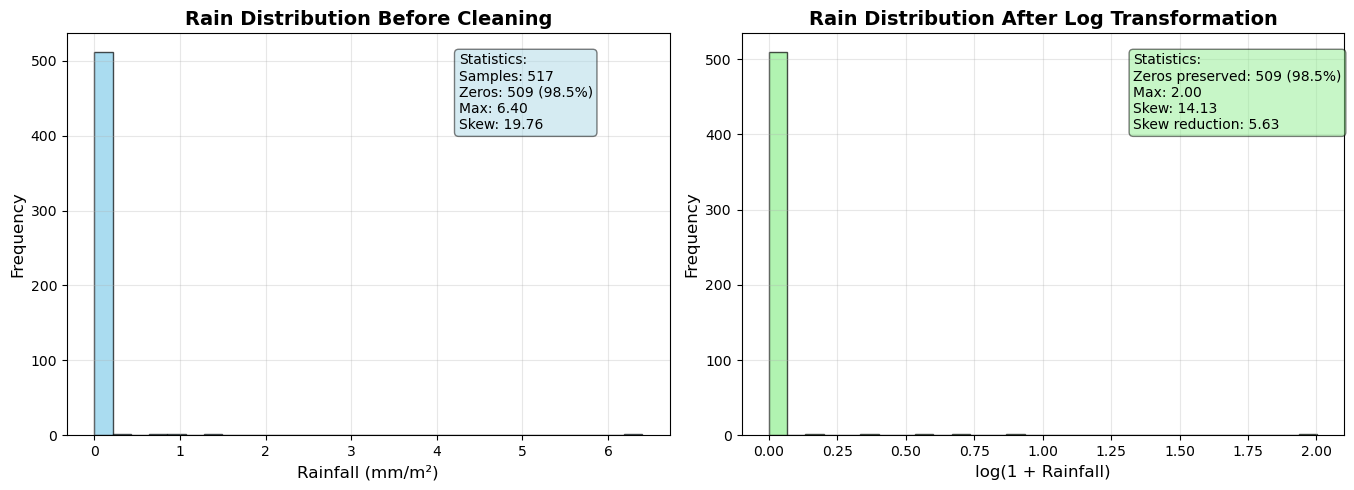

In [25]:
print("\n--- Data Preparation: Rain Variable Cleaning ---")

# ======= 添加统计信息计算 =======
# 计算零值比例
zero_count = (df['rain'] == 0).sum()
total_count = len(df)
zero_percentage = (zero_count / total_count) * 100

print(f"Rain variable analysis:")
print(f"  - Zero values: {zero_count}/{total_count} = {zero_percentage:.1f}%")
print(f"  - Max rainfall: {df['rain'].max():.2f} mm")

# 可选：计算偏度
from scipy.stats import skew
rain_skew = skew(df['rain'])
print(f"  - Skewness (before): {rain_skew:.2f}")

# 计算变换后的偏度
rain_log = np.log1p(df['rain'])
rain_log_skew = skew(rain_log)
print(f"  - Skewness (after log): {rain_log_skew:.2f}")
print(f"  - Skewness reduction: {rain_skew - rain_log_skew:.2f}")
# ======= 统计信息计算结束 =======

# 绘制清洗前后的直方图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 清洗前直方图
ax1.hist(df['rain'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Rain Distribution Before Cleaning', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rainfall (mm/m²)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)

# 在直方图上添加统计信息框
stats_text_before = f'Statistics:\nSamples: {total_count}\nZeros: {zero_count} ({zero_percentage:.1f}%)\nMax: {df["rain"].max():.2f}\nSkew: {rain_skew:.2f}'
ax1.text(0.65, 0.95, stats_text_before, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# 清洗后直方图
ax2.hist(rain_log, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('Rain Distribution After Log Transformation', fontsize=14, fontweight='bold')
ax2.set_xlabel('log(1 + Rainfall)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)

# 在直方图上添加统计信息框
stats_text_after = f'Statistics:\nZeros preserved: {zero_count} ({zero_percentage:.1f}%)\nMax: {rain_log.max():.2f}\nSkew: {rain_log_skew:.2f}\nSkew reduction: {rain_skew - rain_log_skew:.2f}'
ax2.text(0.65, 0.95, stats_text_after, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig('rain_cleaning_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
X = df_processed.drop('area', axis=1)
y = df_processed['area']

# First split: train+val vs test (85%/15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Second split: train vs val (70%/15% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42
)  # 0.176 ≈ 15%/85%

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (361, 12), Val: (78, 12), Test: (78, 12)


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [31]:
def train_random_forest(X_train, y_train, X_val, y_val):
    """Random Forest with Grid Search"""
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best RF params: {grid_search.best_params_}")
    print(f"Best RF validation F1: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_

def train_svm(X_train, y_train, X_val, y_val):
    """SVM with Grid Search"""
    svm = SVC(random_state=42, probability=True)
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best SVM params: {grid_search.best_params_}")
    print(f"Best SVM validation F1: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_

def train_neural_network(X_train, y_train, X_val, y_val):
    """Neural Network with Random Search"""
    nn = MLPClassifier(random_state=42, max_iter=500)
    param_dist = {
        'hidden_layer_sizes': [(32,), (64,), (32,32), (64,64)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
    random_search = RandomizedSearchCV(nn, param_dist, n_iter=20, cv=5, 
                                       scoring='f1', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    print(f"Best NN params: {random_search.best_params_}")
    print(f"Best NN validation F1: {random_search.best_score_:.3f}")
    
    return random_search.best_estimator_

# Train all models
print("\n--- Training Random Forest ---")
rf_model = train_random_forest(X_train_scaled, y_train, X_val_scaled, y_val)

print("\n--- Training SVM ---")
svm_model = train_svm(X_train_scaled, y_train, X_val_scaled, y_val)

print("\n--- Training Neural Network ---")
nn_model = train_neural_network(X_train_scaled, y_train, X_val_scaled, y_val)


--- Training Random Forest ---
Best RF params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best RF validation F1: 0.886

--- Training SVM ---
Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM validation F1: 0.769

--- Training Neural Network ---
Best NN params: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (64,), 'alpha': 0.01, 'activation': 'relu'}
Best NN validation F1: 0.789


In [33]:
print("\n--- Model Selection ---")
models = {'RF': rf_model, 'SVM': svm_model, 'NN': nn_model}
best_model_name = None
best_score = 0

for name, model in models.items():
    y_val_pred = model.predict(X_val_scaled)
    score = f1_score(y_val, y_val_pred)
    print(f"{name} Validation F1: {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model

print(f"\nSelected model: {best_model_name}")

# Train final model on combined train+val data
print("\n--- Training Final Model on Combined Data ---")
X_final_train = np.vstack([X_train_scaled, X_val_scaled])
y_final_train = pd.concat([y_train, y_val])

final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
final_model.fit(X_final_train, y_final_train)


--- Model Selection ---
RF Validation F1: 0.871
SVM Validation F1: 0.727
NN Validation F1: 0.795

Selected model: RF

--- Training Final Model on Combined Data ---


RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [35]:
print("\n--- Test Set Evaluation ---")
y_test_pred = final_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
print(f"\nClassification Report:\n{classification_report(y_test, y_test_pred)}")


--- Test Set Evaluation ---
Accuracy: 0.897
Precision: 0.929
Recall: 0.886
F1-Score: 0.907

Confusion Matrix:
[[31  3]
 [ 5 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.93      0.89      0.91        44

    accuracy                           0.90        78
   macro avg       0.89      0.90      0.90        78
weighted avg       0.90      0.90      0.90        78



In [37]:
print("\n--- Feature Importance ---")
importances = final_model.feature_importances_
feature_names = X.columns

for name, importance in sorted(zip(feature_names, importances), 
                               key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance:.3f}")


--- Feature Importance ---
DMC: 0.256
DC: 0.255
temp: 0.100
month: 0.080
FFMC: 0.072
ISI: 0.059
RH: 0.056
wind: 0.039
Y: 0.032
X: 0.026
day: 0.025
rain: 0.000


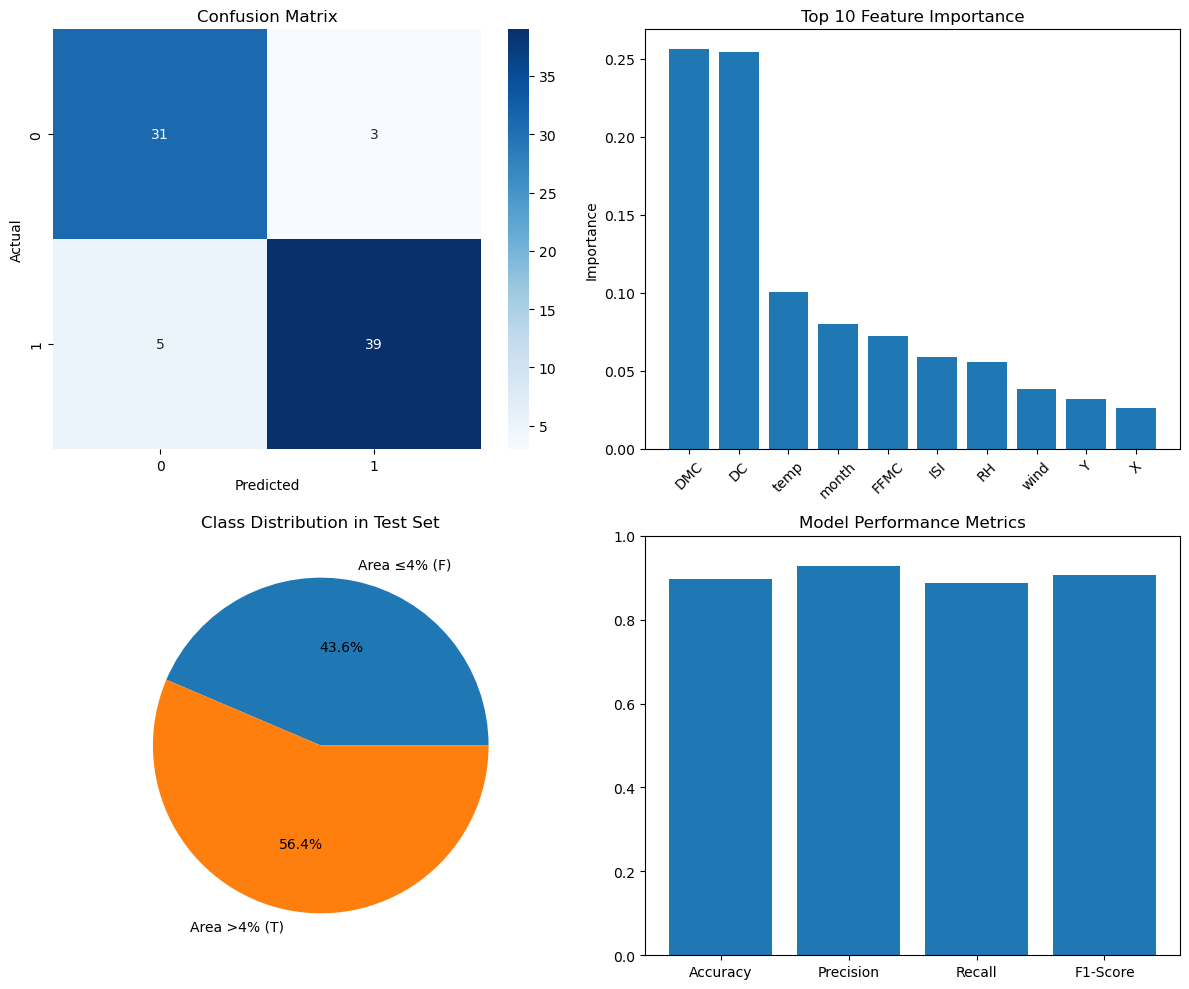


=== Analysis Complete ===


In [39]:
def plot_results(y_true, y_pred, feature_names, importances):
    """Create visualization plots"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # Feature Importance Bar Plot
    indices = np.argsort(importances)[::-1][:10]
    axes[0,1].bar(range(10), importances[indices])
    axes[0,1].set_xticks(range(10))
    axes[0,1].set_xticklabels([feature_names[i] for i in indices], rotation=45)
    axes[0,1].set_title('Top 10 Feature Importance')
    axes[0,1].set_ylabel('Importance')
    
    # Class Distribution
    axes[1,0].pie([sum(y_true==0), sum(y_true==1)], 
                  labels=['Area ≤4% (F)', 'Area >4% (T)'],
                  autopct='%1.1f%%')
    axes[1,0].set_title('Class Distribution in Test Set')
    
    # Performance Metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]
    axes[1,1].bar(metrics, values)
    axes[1,1].set_title('Model Performance Metrics')
    axes[1,1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('model_results.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_results(y_test, y_test_pred, feature_names, importances)

print("\n=== Analysis Complete ===")